# Circadian Detection Pipeline

In [471]:
import logging

import os
import sys
root_dir = os.path.abspath(os.path.join(os.path.dirname('__file__'), '../..'))
sys.path.append(root_dir)

import numpy as np
import pandas as pd

from importlib import reload

from memory import garbage_collect

log = lambda msg: logging.info(msg)


# Load data

In [5]:
from sleep_events import load_days_data

day_data = load_days_data(True)

In [475]:
%%capture

import circadian
reload(circadian)


first_day_with_data = '2024-07-14'
today = '2025-03-25'

all_days = [d.strftime('%Y-%m-%d') for d in pd.date_range(first_day_with_data, today)]

all_raw_data = circadian.fetch_raw_data(literally_all_days)


In [487]:
import circadian
reload(circadian)

all_processed = circadian.process_raw_data(all_raw_data)


c:\dev\Brainwave-Processor\notebooks\CircadianDetection\circadian.py:135: FutureWarning: The behavior of Series.idxmin with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  local_valley_idx = window.idxmin()
c:\Users\graha\.conda\envs\3.10-tf\lib\site-packages\pandas\core\generic.py:4106: RuntimeWarning: invalid value encountered in cast
  indices = np.asarray(indices, dtype=np.intp)


In [ ]:
import circadian
reload(circadian)

cr, cr_df = circadian.get_circadian_reviews()

# Extracting & drawing features

In [520]:
joined_lep_df = None
joined_lt1_df = None


In [ ]:
def merge_all_types():
    out = []
    if joined_lep_df is not None:
        out.append(joined_lep_df)
    if joined_lt1_df is not None:
        out.append(joined_lt1_df)
    
    if len(out) == 0:
        return None
    if len(out) == 1:
        return out[0]
    
    # Merge all DataFrames in the list
    result = out[0]
    for df in out[1:]:
        result = pd.merge(result, df, on='dayAndNightOf', how='outer')
    
    # Detect types and create merged columns
    types = set()
    for col in result.columns:
        if col.endswith('_cr_datetime'):
            type_name = col.split('_cr_')[0]
            types.add(type_name)
    
    # Create merged columns for each type
    for type_name in types:
        # Datetime
        cr_datetime = f'{type_name}_cr_datetime'
        det_datetime = f'{type_name}_det_time'
        result[f'{type_name}_merge_datetime'] = result[cr_datetime].fillna(result[det_datetime])
        
        # Temperature
        cr_temp = f'{type_name}_cr_temp'
        det_temp = f'{type_name}_det_temp'
        result[f'{type_name}_merge_temp'] = result[cr_temp].fillna(result[det_temp])
        
        # Prominence (only exists in cr data)
        if f'{type_name}_cr_prominence' in result.columns:
            result[f'{type_name}_merge_prominence'] = result[f'{type_name}_cr_prominence']
    
    return result

merge_all_types().head()

,dayAndNightOf,LEP_cr_datetime,LEP_cr_temp,LEP_cr_prominence,LEP_det_type,LEP_det_status,LEP_det_reason,LEP_det_time,LEP_det_temp,LEP_diff,...,LT1_det_reason,LT1_det_time,LT1_det_temp,LT1_diff,LEP_merge_datetime,LEP_merge_temp,LEP_merge_prominence,LT1_merge_datetime,LT1_merge_temp,LT1_merge_prominence
0,2024-07-14,2024-07-14 22:48:00+01:00,37.02,0.405,LEP,Detected,Selected last peak of the evening (no historical data available),2024-07-14 22:47:00+01:00,37.02,0 days 00:01:00,...,No relevant valleys found,NaT,NaN,NaT,2024-07-14 22:48:00+01:00,37.02,0.405,NaT,NaN,NaN
1,2024-07-15,2024-07-15 22:36:00+01:00,37.17,0.180,LEP,Detected,Selected last peak of the evening (no historical data available),2024-07-15 22:34:00+01:00,37.17,0 days 00:02:00,...,Selected first stable valley at 00:29,2024-07-16 00:29:00+01:00,36.32,0 days 00:03:00,2024-07-15 22:36:00+01:00,37.17,0.180,2024-07-16 00:32:00+01:00,36.32,0.61
2,2024-07-16,2024-07-16 23:14:00+01:00,37.09,0.720,LEP,Detected,Selected last peak of the evening (no historical data available),2024-07-16 23:16:00+01:00,37.09,0 days 00:02:00,...,No relevant valleys found,NaT,NaN,NaT,2024-07-16 23:14:00+01:00,37.09,0.720,NaT,NaN,NaN
3,2024-07-17,2024-07-17 23:28:00+01:00,37.05,0.140,LEP,Detected,Use 21:44 from ['21:44'] as it's closest to historical average of 22:52,2024-07-17 21:44:00+01:00,37.06,0 days 01:44:00,...,No relevant valleys found,NaT,NaN,NaT,2024-07-17 23:28:00+01:00,37.05,0.140,NaT,NaN,NaN
4,2024-07-18,NaT,NaN,NaN,LEP,Not found,No usable peaks found,NaT,NaN,NaT,...,No relevant valleys found,NaT,NaN,NaT,NaT,NaN,NaN,NaT,NaN,NaN


In [665]:
import circadian
reload(circadian)

post_lep_stats = circadian.calc_avg_mins_after_lep(all_processed, merge_all_types(), 2.5 * 60)
post_lep_stats.describe()

,minute,mean,std1_lower,std1_upper,std2_lower,std2_upper
count,151.000000,151.000000,151.000000,151.000000,151.000000,151.000000
mean,75.000000,36.708057,36.539215,36.876900,36.370373,37.045742
std,43.734045,0.203149,0.203487,0.203473,0.204483,0.204454
min,0.000000,36.460661,36.315211,36.602198,36.155771,36.743735
25%,37.500000,36.506931,36.336649,36.677213,36.174122,36.847496
50%,75.000000,36.686022,36.502261,36.868829,36.318499,37.048945
75%,112.500000,36.874962,36.710190,37.039734,36.545418,37.204506
max,150.000000,37.088063,36.922954,37.253173,36.757844,37.418282


In [708]:
import circadian
reload(circadian)


def do_it_all(day: str, start_time: str = '06:00:00Z', end_time: str = '12:00:00Z'):
    merged = merge_all_types()
    chart = circadian.do_it_all(day_data, day, start_time, end_time, merged, all_processed, post_lep_stats)
    display(chart)
    vs_lep_avg = circadian.compare_night_to_average(all_processed, merged, post_lep_stats, day)
    display(vs_lep_avg)

do_it_all('2024-08-06', '19:00:00Z', '08:00:00Z') 

c:\Users\graha\.conda\envs\3.10-tf\lib\site-packages\urllib3\connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'examined-life.co.uk'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


alt.VConcatChart(...)

{'mean_deviation': 0.09971479750115056,
 'max_deviation': 0.2666783633415051,
 'min_deviation': 0.027577731394480054,
 'minutes_above_1std': 13,
 'minutes_below_1std': 0,
 'minutes_within_1std': 107,
 'longest_above_mean': 115,
 'longest_below_mean': 0,
 'area_above_mean': 11.816468158605037,
 'area_below_mean': 0.0}

# Detecting LEP

In [501]:
import circadian
reload(circadian)

cr_known_lep = circadian.cr_known(cr_df, 'LEP')
cr_known_lep.head()

,dayAndNightOf,LEP_cr_datetime,LEP_cr_temp,LEP_cr_prominence
0,2024-07-14,2024-07-14 22:48:00+01:00,37.02,0.405
1,2024-07-15,2024-07-15 22:36:00+01:00,37.17,0.180
2,2024-07-16,2024-07-16 23:14:00+01:00,37.09,0.720
3,2024-07-17,2024-07-17 23:28:00+01:00,37.05,0.140
7,2024-07-21,2024-07-21 22:40:00+01:00,36.97,0.340


In [523]:
import circadian
reload(circadian)

joined_lep_df, does_not_match_cr_lep = circadian.detect_leps(all_processed, cr_known_lep)

display(joined_lep_df['LEP_diff'].describe())
pd.set_option('display.max_colwidth', None)
pd.set_option('display.width', None)

does_not_match_cr_lep.head()


count                           99
mean     0 days 00:06:21.212121212
std      0 days 00:20:12.616729266
min                0 days 00:00:00
25%                0 days 00:01:00
50%                0 days 00:01:00
75%                0 days 00:02:00
max                0 days 02:16:00
Name: LEP_diff, dtype: object

,dayAndNightOf,LEP_cr_datetime,LEP_cr_temp,LEP_cr_prominence,LEP_det_type,LEP_det_status,LEP_det_reason,LEP_det_time,LEP_det_temp,LEP_diff
248,2025-03-19,2025-03-19 22:36:00+00:00,37.01,0.39,LEP,Detected,"Use 20:20 from ['20:20', '22:37', '23:54'] as it's closest to historical average of 20:52",2025-03-19 20:20:00+00:00,36.72,0 days 02:16:00
3,2024-07-17,2024-07-17 23:28:00+01:00,37.05,0.14,LEP,Detected,Use 21:44 from ['21:44'] as it's closest to historical average of 22:52,2024-07-17 21:44:00+01:00,37.06,0 days 01:44:00
68,2024-09-20,2024-09-20 22:52:00+01:00,37.00,0.18,LEP,Detected,"Use 21:31 from ['21:31', '22:55'] as it's closest to historical average of 22:03",2024-09-20 21:31:00+01:00,37.04,0 days 01:21:00
28,2024-08-11,2024-08-11 23:00:00+01:00,37.05,0.07,LEP,Detected,"Use 21:59 from ['21:59', '23:00'] as it's closest to historical average of 21:30",2024-08-11 21:59:00+01:00,37.06,0 days 01:01:00
24,2024-08-07,2024-08-07 21:58:00+01:00,37.24,NaN,LEP,Detected,"Use 21:21 from ['20:15', '21:21', '21:59'] as it's closest to historical average of 21:09",2024-08-07 21:21:00+01:00,37.23,0 days 00:37:00


In [574]:
import circadian
reload(circadian)


display(circadian.display_stats(joined_lep_df, lep_does_not_match_cr_days, 'LEP'))

In [524]:
joined_lep_df

,dayAndNightOf,LEP_cr_datetime,LEP_cr_temp,LEP_cr_prominence,LEP_det_type,LEP_det_status,LEP_det_reason,LEP_det_time,LEP_det_temp,LEP_diff
0,2024-07-14,2024-07-14 22:48:00+01:00,37.02,0.405,LEP,Detected,Selected last peak of the evening (no historical data available),2024-07-14 22:47:00+01:00,37.020000,0 days 00:01:00
1,2024-07-15,2024-07-15 22:36:00+01:00,37.17,0.180,LEP,Detected,Selected last peak of the evening (no historical data available),2024-07-15 22:34:00+01:00,37.170000,0 days 00:02:00
2,2024-07-16,2024-07-16 23:14:00+01:00,37.09,0.720,LEP,Detected,Selected last peak of the evening (no historical data available),2024-07-16 23:16:00+01:00,37.090000,0 days 00:02:00
3,2024-07-17,2024-07-17 23:28:00+01:00,37.05,0.140,LEP,Detected,Use 21:44 from ['21:44'] as it's closest to historical average of 22:52,2024-07-17 21:44:00+01:00,37.060000,0 days 01:44:00
4,2024-07-18,NaT,NaN,NaN,LEP,Not found,No usable peaks found,NaT,NaN,NaT
...,...,...,...,...,...,...,...,...,...,...
250,2025-03-21,NaT,NaN,NaN,LEP,Detected,Use 21:21 from ['21:21'] as it's closest to historical average of 20:43,2025-03-21 21:21:00+00:00,37.190000,NaT
251,2025-03-22,NaT,NaN,NaN,LEP,Detected,Use 22:52 from ['22:52'] as it's closest to historical average of 21:00,2025-03-22 22:52:00+00:00,36.677143,NaT
252,2025-03-23,NaT,NaN,NaN,LEP,Detected,Use 21:27 from ['21:27'] as it's closest to historical average of 21:51,2025-03-23 21:27:00+00:00,36.905577,NaT
253,2025-03-24,NaT,NaN,NaN,LEP,Detected,Use 21:44 from ['21:44'] as it's closest to historical average of 21:53,2025-03-24 21:44:00+00:00,37.220000,NaT


In [542]:
# Nights where it's going to be pretty tricky for the algo, for instance.
# It's ok to mark up some nights manually.
lep_tricky_nights = [
    # A double peak and I have correctly labelled the later one as LEP but can see why the algo chooses the first (closer to historical avg)
    '2024-09-20', '2024-08-11',

    # Algo has chosen a better peak but my UI won't let me correct mine
    '2024-09-12',

    # Very early data when CR is messed up
    '2024-07-25'
]

# This is just temporary, it should be fixed in the UI now
lep_fixed_my_own = []

lep_does_not_match_cr_days = does_not_match_cr_lep['dayAndNightOf'].unique()
lep_does_not_match_cr_days = [bd for bd in lep_does_not_match_cr_days if bd not in lep_fixed_my_own and bd not in lep_tricky_nights]
lep_does_not_match_cr_days


['2025-03-19',
 '2024-07-17',
 '2024-08-07',
 '2024-09-05',
 '2024-08-10',
 '2024-12-02',
 '2024-11-29',
 '2024-10-30']

In [526]:
do_it_all('2024-07-17', '19:00:00Z', '08:00:00Z')
# df, dd = get_data_for_day('2024-08-29')
# df.head()


TypeError: string indices must be integers

To solve:
* If there's no data values around where we expect LEP ot be (2025-01-05)


# Detecting LT1 

In [503]:
import circadian
reload(circadian)

cr_known_lt1 = circadian.cr_known(cr_df, 'LT1')
cr_known_lt1.head()

,dayAndNightOf,LT1_cr_datetime,LT1_cr_temp,LT1_cr_prominence
1,2024-07-15,2024-07-16 00:32:00+01:00,36.32,0.61
7,2024-07-21,2024-07-22 00:30:00+01:00,36.31,0.53
8,2024-07-22,2024-07-23 00:32:00+01:00,36.40,0.26
9,2024-07-23,2024-07-24 01:04:00+01:00,36.43,0.11
10,2024-07-24,2024-07-25 00:54:00+01:00,36.37,0.21


In [513]:
import circadian
reload(circadian)

# Test
# lt1_det_df = circadian.extract_lt1(all_processed)
# lt1_det_df.head()


,dayAndNightOf,LT1_det_status,LT1_det_reason,LT1_det_time,LT1_det_temp
0,2024-07-14,Not found,No relevant valleys found,NaT,NaN
1,2024-07-15,Detected,Selected first stable valley at 00:29,2024-07-16 00:29:00+01:00,36.32
2,2024-07-16,Not found,No relevant valleys found,NaT,NaN
3,2024-07-17,Not found,No relevant valleys found,NaT,NaN
4,2024-07-18,Not found,No relevant valleys found,NaT,NaN


In [538]:
import circadian
reload(circadian)

merged = merge_all_types()
joined_lt1_df, does_not_match_cr_lt1 = circadian.detect_lt1(all_processed, cr_known_lt1, merged)

display(joined_lt1_df['LT1_diff'].describe())
display(len(does_not_match_cr_lt1))

does_not_match_cr_lt1.head()

count                           26
mean     0 days 00:38:11.538461538
std      0 days 00:52:05.672653759
min                0 days 00:00:00
25%                0 days 00:02:00
50%                0 days 00:07:30
75%                0 days 00:48:00
max                0 days 02:43:00
Name: LT1_diff, dtype: object

13

,dayAndNightOf,LT1_cr_datetime,LT1_cr_temp,LT1_cr_prominence,LT1_det_status,LT1_det_reason,LT1_det_time,LT1_det_temp,LT1_diff
23,2024-08-06,2024-08-07 02:02:00+01:00,36.40,NaN,Detected,Selected first stable valley at 23:19 (after LEP at 21:48),2024-08-06 23:19:00+01:00,36.66,0 days 02:43:00
31,2024-08-14,2024-08-15 02:04:00+01:00,36.36,0.48,Detected,Selected first stable valley at 23:35 (after LEP at 22:10),2024-08-14 23:35:00+01:00,36.49,0 days 02:29:00
17,2024-07-31,2024-08-01 02:54:00+01:00,36.55,NaN,Detected,Selected first stable valley at 00:34 (after LEP at 23:40),2024-08-01 00:34:00+01:00,37.13,0 days 02:20:00
45,2024-08-28,2024-08-29 01:30:00+01:00,36.43,0.73,Detected,Selected first stable valley at 23:45 (after LEP at 21:44),2024-08-28 23:45:00+01:00,36.48,0 days 01:45:00
28,2024-08-11,2024-08-12 01:34:00+01:00,36.38,0.16,Detected,Selected first stable valley at 23:50 (after LEP at 23:00),2024-08-11 23:50:00+01:00,36.48,0 days 01:44:00


In [570]:
display(display_stats(joined_lt1_df, does_not_match_cr_lt1, 'LT1'))

In [638]:
do_it_all('2024-07-31', '19:00:00Z', '08:00:00Z') 

c:\Users\graha\.conda\envs\3.10-tf\lib\site-packages\urllib3\connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'examined-life.co.uk'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


alt.VConcatChart(...)

# Exploring initial drop after LEP

Identifying LT1 is proving tricky.  It doesn't always plummet in a nice clean way to a nice clean bottom.

Might be easier to identify features like amount of drop in first 2 hours after LEP.

Or % of total night's low covered in first 2 hours.

May be interesting to see all charts on one, for the first 2 hours after LEP, that sort of thing.

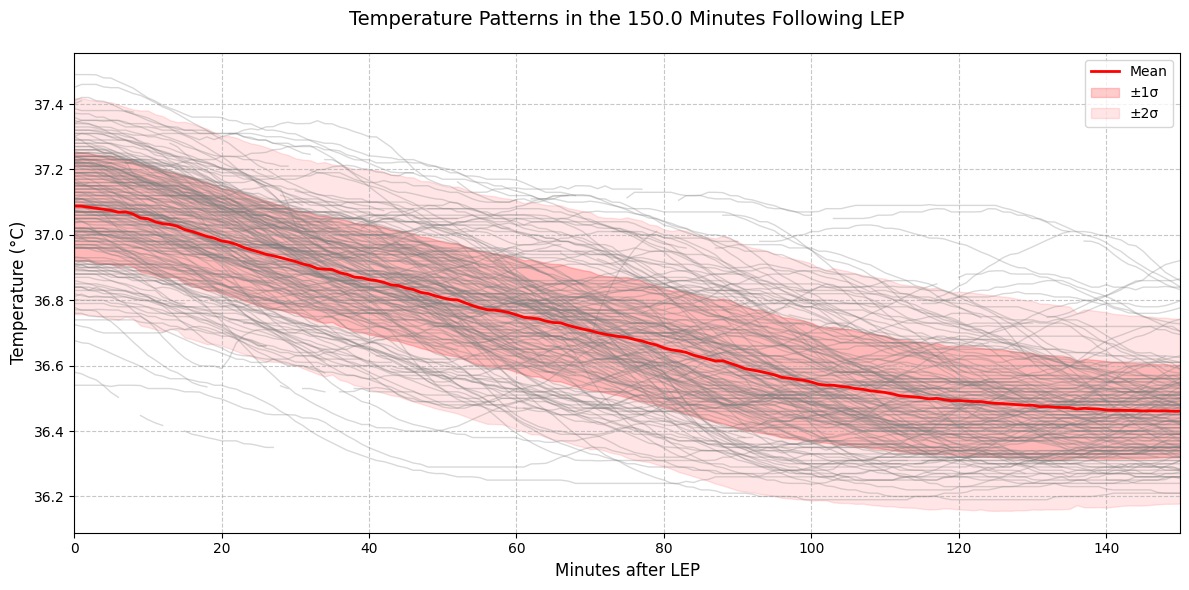

In [637]:
import circadian
reload(circadian)

fig = circadian.plot_post_lep_periods_matplotlib(all_processed, merged, 2.5 * 60)
plt.show()

In [717]:
do_it_all('2025-01-14', '19:00:00Z', '08:00:00Z') 

c:\Users\graha\.conda\envs\3.10-tf\lib\site-packages\urllib3\connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'examined-life.co.uk'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


alt.VConcatChart(...)

{'mean_deviation': -0.26787321509804335,
 'max_deviation': -0.17295265952223104,
 'min_deviation': -0.3860215097923074,
 'minutes_above_1std': 0,
 'minutes_below_1std': 119,
 'minutes_within_1std': 0,
 'longest_above_mean': 0,
 'longest_below_mean': 98,
 'area_above_mean': 0.0,
 'area_below_mean': 31.686416216631606}

nights_failing_to_see_lep = ['2025-03-18']
nights_look_wrong = ['2025-03-15']

Next

* Detect amount of time above and below mean, and how much.
* Look at steep and slow descenders.
* Look at those that don't descend cleanly.
* Do any of these correlate to e.g. more or stronger deep sleep? 

In [718]:
# Create list to store results
all_nights_analysis = []

# Analyze each night
for day in all_processed.keys():
    metrics = compare_night_to_average(all_processed, merged, post_lep_stats, day)
    if metrics is not None:
        metrics['dayAndNightOf'] = day
        all_nights_analysis.append(metrics)

# Convert to DataFrame
nights_df = pd.DataFrame(all_nights_analysis)

# Reorder columns to put dayAndNightOf first
cols = ['dayAndNightOf'] + [col for col in nights_df.columns if col != 'dayAndNightOf']
nights_df = nights_df[cols]

# Sort by date
nights_df = nights_df.sort_values('dayAndNightOf')
nights_df.head()

In [719]:
nights_df.head()

,dayAndNightOf,mean_deviation,max_deviation,min_deviation,minutes_above_1std,minutes_below_1std,minutes_within_1std,longest_above_mean,longest_below_mean,area_above_mean,area_below_mean
0,2024-07-14,-0.071559,-0.039388,-0.144451,0,0,30,0,91,0.000000,2.040512
1,2024-07-15,-0.007813,0.160740,-0.199946,0,23,92,55,66,7.013452,7.866058
2,2024-07-16,0.079573,0.159132,0.002305,0,0,60,54,0,4.693672,0.000000
3,2024-07-17,-0.072730,-0.024718,-0.173766,0,3,31,0,87,0.000000,2.367027
4,2024-07-21,-0.149131,-0.103605,-0.220216,0,29,74,0,42,0.000000,15.214804


In [720]:
day_data.head()

,dayAndNightOf,date:daysSince,date:dayOfWeek,date:dayOfMonth,date:month,date:year,date:asStr,weather:cloudCoverAfternoon,weather:humidityAfternoon,weather:precipitationTotal,...,ereader:allDay:entriesCount,ereader:gotIntoBedToAsleep:entriesCount,ereader:beforeEvening:entriesCount,ereader:eveningToBed:entriesCount,asleepTime,wakeTime,gotIntoBedTime,readyToSleepTime,LEPTime,timeAwakeAfterSleep
0,2025-02-03,0,1,3,2,2025,2025-02-03,20,77.0,0.00,...,NaN,NaN,NaN,NaN,2025-02-03 23:04:30+00:00,2025-02-04 04:25:00+00:00,2025-02-03 21:09:51+00:00,2025-02-03 22:58:30+00:00,NaT,0 days 00:06:00
1,2024-04-21,0,7,21,4,2024,2024-04-21,40,56.0,2.37,...,NaN,NaN,NaN,NaN,NaT,NaT,NaT,NaT,NaT,NaT
2,2024-04-22,0,1,22,4,2024,2024-04-22,75,95.0,4.06,...,NaN,NaN,NaN,NaN,NaT,NaT,NaT,NaT,NaT,NaT
3,2024-04-23,0,2,23,4,2024,2024-04-23,40,69.0,0.00,...,NaN,NaN,NaN,NaN,NaT,NaT,NaT,NaT,NaT,NaT
4,2024-04-24,0,3,24,4,2024,2024-04-24,40,61.0,0.00,...,NaN,NaN,NaN,NaN,NaT,NaT,NaT,NaT,NaT,NaT


In [723]:
# Convert dayAndNightOf to string in both dataframes
nights_df['dayAndNightOf'] = nights_df['dayAndNightOf'].astype(str)
day_data['dayAndNightOf'] = day_data['dayAndNightOf'].astype(str)

# Merge the dataframes
merged_for_corr = pd.merge(nights_df, day_data, on='dayAndNightOf', how='inner')

# Get numeric columns from day_data
numeric_cols = day_data.select_dtypes(include=['int64', 'float64']).columns

# Calculate correlations with valid counts
correlations = []
for col in numeric_cols:
    # Count valid pairs (where both columns have non-null values)
    valid_count = merged_for_corr[['area_below_mean', col]].dropna().shape[0]
    
    if valid_count >= 10:  # Only calculate correlation if we have enough data
        correlation = merged_for_corr['area_below_mean'].corr(merged_for_corr[col])
        correlations.append({
            'column': col,
            'correlation': correlation,
            'valid_count': valid_count
        })

# Convert to DataFrame and sort by absolute correlation
corr_df = pd.DataFrame(correlations)
corr_df['abs_correlation'] = corr_df['correlation'].abs()
corr_df = corr_df.sort_values('abs_correlation', ascending=False)
corr_df = corr_df.drop('abs_correlation', axis=1)

# Display top correlations
print("Top correlations with area_below_mean (minimum 10 valid pairs):")
display(corr_df)

c:\Users\graha\.conda\envs\3.10-tf\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\graha\.conda\envs\3.10-tf\lib\site-packages\numpy\lib\function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
c:\Users\graha\.conda\envs\3.10-tf\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\graha\.conda\envs\3.10-tf\lib\site-packages\numpy\lib\function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
c:\Users\graha\.conda\envs\3.10-tf\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\graha\.conda\envs\3.10-tf\lib\site-packages\numpy\lib\function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
c:\Users\graha\.conda\envs\3.10-tf

Top correlations with area_below_mean (minimum 10 valid pairs):


c:\Users\graha\.conda\envs\3.10-tf\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\graha\.conda\envs\3.10-tf\lib\site-packages\numpy\lib\function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
c:\Users\graha\.conda\envs\3.10-tf\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\graha\.conda\envs\3.10-tf\lib\site-packages\numpy\lib\function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
c:\Users\graha\.conda\envs\3.10-tf\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\graha\.conda\envs\3.10-tf\lib\site-packages\numpy\lib\function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
c:\Users\graha\.conda\envs\3.10-tf

,column,correlation,valid_count
1855,circadian:combined:entries:MP2:minsSinceReadyToSleep:vsDayMinus1,0.932406,10
1818,circadian:combined:entries:MEP:minsSinceSunriseEnd:vsDayMinus1,-0.811321,13
1806,circadian:combined:entries:MEP:datetimeSSM:vsDayMinus1,-0.810922,13
1794,circadian:basic:entries:MEP:datetimeSSM:vsDayMinus1,-0.810922,13
1816,circadian:combined:entries:MEP:minsSinceSunsetEnd:vsDayMinus1,-0.808656,13
...,...,...,...
2065,events:startingPaidWork:count,NaN,23
2100,events:luminette:count,NaN,24
2102,events:sexWithClimax:count,NaN,29
2103,events:sexWithoutClimax:count,NaN,29


In [732]:
cols_to_include = [c for c in corr_df['column'] if not (c.startswith('circadian') or c.startswith('coreBodyTemp'))]
use = corr_df[corr_df['column'].isin(cols_to_include)]
df = use[use['correlation'].abs() > 0.2]
df

,column,correlation,valid_count
2106,ereader:allDay:endTimeSSM,-0.773576,19
2082,phoneUsage:gotIntoBedToAsleep:categories:Audiobook:lastStartSSM,-0.638827,13
2079,phoneUsage:gotIntoBedToAsleep:categories:Calming:lastStartSSM,-0.593298,14
2074,events:phoneAwayFromBed:firstSSM,0.522821,18
2075,events:phoneAwayFromBed:lastSSM,0.522712,18
...,...,...,...
621,hr:ReadyToSleepToAsleep:mean,-0.201678,113
635,hrv:GotIntoBedToReadyToSleep:percentile10,0.201330,92
594,events:rgm:firstSSM,0.201244,109
608,hr:GotIntoBedToReadyToSleep:percentile90,-0.200673,95


In [ ]:
scatter = alt.Chart(merged_for_corr).mark_circle().encode(
    x=alt.X('events\\:luminetteLevel1\\:firstSSM:Q', 
            title='Luminette Level 1 First SSM',
            scale=alt.Scale(zero=False)),
    y=alt.Y('area_below_mean:Q', 
            title='Area Below Mean',
            scale=alt.Scale(zero=False)),
    tooltip=['dayAndNightOf', 
            alt.Tooltip('events\\:luminetteLevel1\\:firstSSM:Q', format='.1f'),
            alt.Tooltip('area_below_mean:Q', format='.1f')]
).properties(
    width=600,
    height=400,
    title='Area Below Mean vs Luminette Level 1 First SSM'
)

scatter